In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
def norm(p):
    a=np.zeros(len(p))
    a=(p-p.mean())/(np.std(p)+1e-15)
    return a

def normalize(x):
    m,n=x.shape
    p=np.zeros(n)
    x1=np.zeros((m,n))
    for i in range(n):
        p=x[:,i]
        a=norm(p)
        x1[:,i]=a
    return x1

def ReLu(z):
    return np.maximum(0,z)

def softmax(z):
    exp_term=np.exp(z-z.max(1).reshape(-1,1))
    denominator=np.sum(exp_term,axis=1)+1e-15
    softmax_probs=exp_term/denominator.reshape(-1,1)
    return softmax_probs
def relu_der(x):
    return np.where(x > 0, 1, 0)
def softmax_derivative(a,y):
    return a-y 
def one_hot(y):
    one_hot_y = np.zeros((y.size, int(y.max()) + 1))
    one_hot_y[np.arange(y.size), y.astype(int)] = 1 
    one_hot_y = one_hot_y.T
    return one_hot_y

In [25]:
def xavier_uniform(m,n):    
    scale = np.sqrt(6.0 /(m+n))
    return np.random.uniform(-scale, scale, size=(m,n))

In [26]:

def init_params(input_,units):
    np.random.seed(1127825)
    w=[]
    b=[]
    w1=xavier_uniform(units[0],len(input_[0]))
    b1=xavier_uniform(units[0],1)
    w.append(w1)
    b.append(b1)
    for i in range(1,len(units)):
        w2=xavier_uniform(units[i],units[i-1])
        w.append(w2)
        b2=xavier_uniform(units[i],1)
        b.append(b2)
    return w,b

In [27]:
s=xavier_uniform(10,24)
s.shape

(10, 24)

In [36]:
class neural_network1:
    def __init__(self,learning_rate=None,epoch=None):
        self.lr=learning_rate
        self.epoch=epoch
    def fit(self,x,y):
        self.x=normalize(x)
        self.y=y

    def layers(self,hidden_layers):
        self.num_layers=len(hidden_layers)
        self.hidden_layers=hidden_layers

    def dense(self,x,w,b,activation):
        z=np.dot(x,w.T)+b.T
        a=activation(z)
        return z,a

    def forward_prop(self,input_):
        a=[]
        z=[]
        z2,a2=self.dense(input_,self.w[0],self.b[0],ReLu)
        a.append(a2)
        z.append(z2)
        for i in range(1,self.num_layers-1):
            z2,a2=self.dense(a2,self.w[i],self.b[i],ReLu)
            a.append(a2)
            z.append(z2)
        zn,an=self.dense(a2,self.w[-1],self.b[-1],softmax)
        #print("z[-1] forward",np.unique(zn))
        an= np.where(np.isnan(an), np.clip(an, a_min=0, a_max=0), an)
        a.append(an)
        z.append(zn)
        return z,a

    def cost_func(self,a,y):
        m,n=y.shape
        a=a[-1]
        l=-y*np.log(a.T+1e-15)/n
        self.loss=l.sum()

    def backprop(self,z,a,x,y):
        m,n=y.shape
        dw=[]
        db=[]
        loss=-y*np.log(1e-15+a[-1].T)
        dan=-y/(1e-15+a[-1].T)
        dzn=softmax_derivative(a[-1].T,y)
        #dzn=y-a[-1].T
        dwn=np.dot(dzn,a[-2])/n
        dbn=dzn.sum(1)/n
        dw.append(dwn)
        db.append(dbn)
        for i in range(self.num_layers-1,1,-1):
            dai=np.dot(self.w[i].T,dzn)
            dzi=dai*relu_der(z[i-1].T)
            dwi=np.dot(dzi,a[i-2])/n
            dbi=dzi.sum(1)/n
            dzn=dzi
            dw.append(dwi)
            db.append(dbi)
        da1=np.dot(self.w[1].T,dzn)
        dz1=da1*relu_der(z[0].T)
        dw1=np.dot(dz1,x)/n
        db1=dz1.sum(1)/n
        dw.append(dw1)
        db.append(db1)
        dw,db=dw[::-1],db[::-1]
        return dw,db
        

    def update_params(self,batch):
        
        m,n=self.x.shape
        q=np.arange(m)
        q=np.random.permutation(q)
        gw=np.ones(self.num_layers)
        gb=np.ones(self.num_layers)
        c=m//batch
        self.w,self.b=init_params(self.x,self.hidden_layers)
        self.costa=[]
        
        for i in range(self.epoch):
            for k in range(c):
                
                x=self.x[k*batch:(k+1)*batch]
                y=self.y[:,k*batch:(k+1)*batch]
                z,a=self.forward_prop(x)
                dw,db=self.backprop(z,a,x,y)
                for j in range(self.num_layers):
                    self.w[j]-=self.lr*dw[j]
                    self.b[j]-=self.lr*db[j].reshape(-1,1)
                z,a=self.forward_prop(x)
                self.cost_func(a,y)
                self.costa.append(self.loss)
                if i%(self.epoch//10)==0 and k==0:
                    z,a=self.forward_prop(x)
                    self.cost_func(a,y)
                    print("epoch: ",i,"  loss: ",self.loss)

    def prediction(self,x_test):
        z,a=self.forward_prop(normalize(x_test))
        p=z[-1]
        pred=np.argmax(p,axis=1)
        return pred

    def accuracy(self,y_test,pred):
        return np.mean(np.array_equal(y_test,pred))

In [29]:
df=pd.read_csv('Classification_train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
def train_test_split(x,y,test_size):
    m,n=x.shape
    indices=np.arange(m)
    p=np.random.permutation(indices)
    x_test=x[p][:int(m*test_size)]
    y_test=y[p][:int(m*test_size)]
    x_train=x[p][int(m*test_size):]
    y_train=y[p][int(m*test_size):]
    return x_train,y_train,x_test,y_test

In [37]:
y_train=df['label']
y_train=y_train.to_numpy()
x_train=df.drop(['label'],axis=1)
x_train=x_train.to_numpy()

In [38]:
x_train1,y_train1,x_cv,y_cv=train_test_split(x_train/255,y_train,0.2)

In [39]:
model=neural_network1()

In [40]:
model.lr=5e-2

model.epoch=30

In [41]:
model.fit(x_train1,one_hot(y_train1))
model.layers([128,64,32,10])



In [42]:
model.update_params(32)

epoch:  0   loss:  2.0164180965940077
epoch:  3   loss:  0.005333555635184518
epoch:  6   loss:  0.00147755947993791
epoch:  9   loss:  0.00046825033197985704
epoch:  12   loss:  0.0003443537856772026
epoch:  15   loss:  0.0002748077148767127
epoch:  18   loss:  0.00021932053784481885
epoch:  21   loss:  0.00017523686044024716
epoch:  24   loss:  0.00014339708123638808
epoch:  27   loss:  0.00012085597939115469


In [43]:
p=model.prediction(x_cv)  #traning
np.mean(p==y_cv)

0.9851666666666666

In [44]:
q=model.prediction(x_train1)  #cross validation
np.mean(q==y_train1)

1.0

Text(0, 0.5, 'cost')

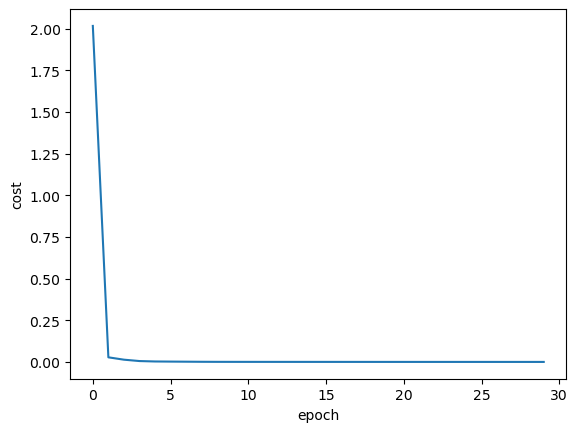

In [45]:
plt.plot(np.arange(30),model.costa[::750])
plt.xlabel('epoch')
plt.ylabel('cost')

In [50]:
ot=pd.read_csv('Classification_test.csv')
otid=ot['ID']
x_test=ot.drop(['ID'],axis=1)

In [51]:
x_test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
x_test=x_test.to_numpy()
opred=model.prediction(x_test)

print(x_test.shape)
opreddf=pd.DataFrame({'Id': otid,'output': opred})
opreddf.to_csv('Classification_output_neural.csv')
opreddf

InvalidIndexError: (slice(None, None, None), 0)